***Machine Learning_Assignment_Zalando_Product_Matching***

#Outline
---
# <font color='#3dc1d3'>  
1. Introduction- (given 3 dataset files, problem statement, expected to do)
2. Install required library, import and read Dataset
3. Exploratory Data Analysis
4. Data Pre-processing
5. Transfer Learning, Pretrained Data. Create Word2Vec for description
7. Content based product matching System; Find similar product between 2 shops <br>







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**1. Introduction**
Zalando is one of the multi-national German e-commerce website it has customers in 23 European markets that can purchase fashion and lifestyle products.

Problem Statement: Zalando intends to offer competitive prices in each of its changing market situations to save clients time comparing prices and to raise profits.

There are three given files, offer training file contains the offer details of the products for both shops zalando and its competitor about you, second file contains the ground truth similar product present for same brands in both shops, and the third file consist of offer details of product for which we need to generate the file of matching products.






#**2. Install required library, import and read Dataset**

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText
!pip install fastText

fatal: destination path 'fastText' already exists and is not an empty directory.


In [ ]:
#Libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
%matplotlib inline
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**3. Exploratory Data Analysis**


##3.1 Dataset:
The dataset contain files as follows.

* Two Offers of products files: Training and Testing
* Matched_product for Training offers for those offers that describes same products using offer ids from training file.

In [ ]:
# Read offer training dataset
df_offer_training = pd.read_parquet("/content/drive/MyDrive/assignment/assignment/offers_training.parquet")
df_offer_training.head(2)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,hellblau | Blau,Kleid,"{""Material"": [""Baumwolle""], ""\u00c4rmell\u00e4...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...
1,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,schwarz | mischfarben | Schwarz,Bikinihose,"{""Leibh\u00f6he"": [""Super Low Waist""], ""Marke""...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...


In [ ]:
# Read matches file for training dataset
df_match_training = pd.read_parquet("/content/drive/MyDrive/assignment/assignment/matches_training.parquet")
df_match_training.head(2)

,zalando,aboutyou,brand
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,10
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,10


In [ ]:
# Read offer testing dataset

df_offer_testing = pd.read_parquet("/content/drive/MyDrive/assignment/assignment/offers_test.parquet")
df_offer_testing.head(2)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,67069c3c-46a7-45ea-ae0f-1cac2571ae68,aboutyou,de,DKNY,beige | Beige,Schal,"{""Marke"": [""DKNY""], ""Gr\u00f6\u00dfenlauf"": [""...",49.99,https://www.aboutyou.de/p/dkny/schal-7221536,[https://cdn.aboutstatic.com/file/images/d8432...
1,c065bcd3-0669-4061-b1ce-fd6467f81b91,aboutyou,de,MICHAEL Michael Kors,schwarz | Mischfarben,Plisseerock,"{""Marke"": [""MICHAEL Michael Kors""], ""Gr\u00f6\...",79.98,https://www.aboutyou.de/p/michael-michael-kors...,[https://cdn.aboutstatic.com/file/images/687cd...


Features of dataset:
Looking at the unique values of each columns in the dataset we can say as follows:
*   offer_id is unique for each record
*   there are 2 shops zalando and aboutyou
*   only german language used so we can drop this column
*   there are total 145 unique brands 
*   color of the product
*   Title columns gives us short desciption about product type i.e. dress or chinos pants so on..
*   Price is the rate for that product in euros
* There are total 33 attributes in the description column used to describe the product.




In [ ]:
#Count of each file with respect to records and attributes present
print('Total number of records and attributes present in dataset')
print(f'Offer training data: {df_offer_training.shape}')
print(f'Offer testing data: {df_offer_testing.shape}')
print(f'Match training data: {df_match_training.shape}')

Total number of records and attributes present in dataset
Offer training data: (102884, 10)
Offer testing data: (106741, 10)
Match training data: (15170, 3)


In [ ]:
#list of columns present in dataset
print(f'Offer training data: {list(df_offer_training.columns)}')
print(f'Offer testing data: {list(df_offer_testing.columns)}')
print(f'Match training data: {list(df_match_training.columns)}')

Offer training data: ['offer_id', 'shop', 'lang', 'brand', 'color', 'title', 'description', 'price', 'url', 'image_urls']
Offer testing data: ['offer_id', 'shop', 'lang', 'brand', 'color', 'title', 'description', 'price', 'url', 'image_urls']
Match training data: ['zalando', 'aboutyou', 'brand']


In [ ]:
#Total records present for each shops
pd.value_counts(df_offer_training['shop'], sort=True, ascending=False)

aboutyou    61980
zalando     40904
Name: shop, dtype: int64

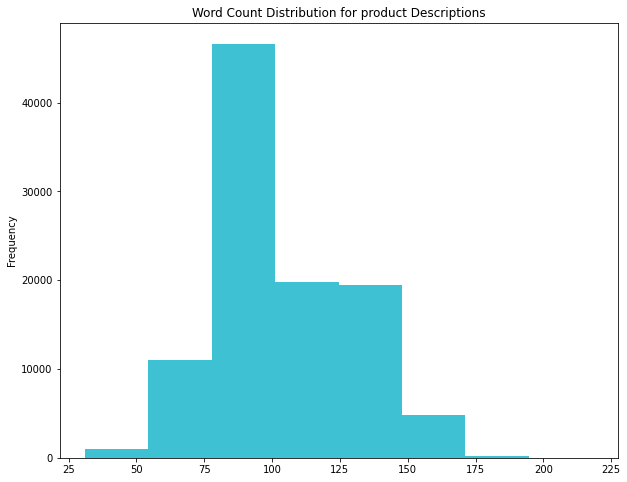

In [ ]:
#Word Count Distribution for product Descriptions
df_offer_training["word_count"] = df_offer_training['description'].apply(lambda x: len(str(x).split()))
ax = df_offer_training['word_count'].plot(
    kind='hist',
    bins=8,
    color='#3dc1d3',
    figsize = (10,8), title="Word Count Distribution for product Descriptions"
)

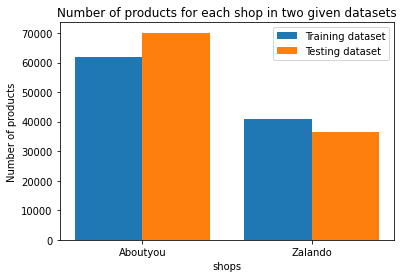

In [ ]:
#Number of products for each shop in two given datasets
X = ['Aboutyou','Zalando']
Training = pd.value_counts(df_offer_training['shop'], sort=True, ascending=False)
Testing = pd.value_counts(df_offer_testing['shop'], sort=True, ascending=False)
  
x_axis = np.arange(len(X))
  
plt.bar(x_axis - 0.2, Training, 0.4, label = 'Training dataset')
plt.bar(x_axis + 0.2, Testing, 0.4, label = 'Testing dataset')
  
plt.xticks(x_axis, X)
plt.xlabel("shops")
plt.ylabel("Number of products")
plt.title("Number of products for each shop in two given datasets")
plt.legend()
plt.show()

#**4. Data Pre-processing**


##4.1. Missing values check <br>


In [ ]:
#check for missing data
print(f'Offer training data: {df_offer_training.isnull().sum()}\n')
print(f'Offer testing data: {df_offer_testing.isnull().sum()}\n')
print(f'Match training data: {df_match_training.isnull().sum()}')

Offer training data: offer_id        0
shop            0
lang            0
brand           0
color           2
title           0
description     0
price           2
url             0
image_urls     26
word_count      0
dtype: int64

Offer testing data: offer_id        0
shop            0
lang            0
brand           0
color          15
title           0
description     0
price           1
url             0
image_urls     57
dtype: int64

Match training data: zalando     0
aboutyou    0
brand       0
dtype: int64


From above we can see the missing data present for only 3 columns color, price and img in both the dataset. as missing values count is not large and since we are not using price and img columns we can skip immputing missing values, and for colors as well since we will be using this column in combination with others.


In [ ]:
#Number of unique records present for each attribute in both files
print("offer_id in Training:    " , len(pd.unique(df_offer_training['offer_id'])),    "\t offer_id in Testing:    " , len(pd.unique(df_offer_testing['offer_id'])))
print("Shop in Training:        ", len(pd.unique(df_offer_training['shop'])),         "\t  \t Shop in Testing:        ", len(pd.unique(df_offer_testing['shop']))  )
print("Lang in Training:        ", len(pd.unique(df_offer_training['lang'])),         "\t \t Lang in Testing:        ", len(pd.unique(df_offer_testing['lang'])) )
print("Brand in Training:       ", len(pd.unique(df_offer_training['brand'])),        "\t \t Brand in Testing:       ", len(pd.unique(df_offer_testing['brand'])) )
print("Color in Training:       ", len(pd.unique(df_offer_training['color'])),        "\t Color in Testing:       ", len(pd.unique(df_offer_testing['color'])) )
print("Title in Training:       ", len(pd.unique(df_offer_training['title'])),        "\t Title in Testing:       ", len(pd.unique(df_offer_testing['title'])))
print("Description in Training: ", len(pd.unique(df_offer_training['description'])),  "\t Description in Testing: ", len(pd.unique(df_offer_testing['description'])) )
print("Price in Training:       ", len(pd.unique(df_offer_training['price'])),        "\t\t Price in Testing:       ", len(pd.unique(df_offer_testing['price'])))
print("Url in Training:         ", len(pd.unique(df_offer_training['url'])),          "\t Url in Testing:         ", len(pd.unique(df_offer_testing['url'])) )

offer_id in Training:     102884 	 offer_id in Testing:     106741
Shop in Training:         2 	  	 Shop in Testing:         2
Lang in Training:         1 	 	 Lang in Testing:         1
Brand in Training:        145 	 	 Brand in Testing:        164
Color in Training:        10139 	 Color in Testing:        12813
Title in Training:        37897 	 Title in Testing:        35577
Description in Training:  101962 	 Description in Testing:  105303
Price in Training:        8350 		 Price in Testing:        9309
Url in Training:          102884 	 Url in Testing:          106741


##4.2. Data Cleaning & Feature selection:
Since i am considering columns offerid, brand, color, title and description we need to clean and create new column for these clean data

In [ ]:
def lower(text):
  return text.lower()

def stop_words(text):
  text = text.split()#split tokens to find stop words
  stops = set(stopwords.words("english"))
  text = [w for w in text if not w in stops]
  text = " ".join(text)
  #join into a string after removing stop words 
  return text 

def clean_html(text):
  html = re.compile('<.*?>')#regex
  return html.sub(r'',text)

def backslash(text):
  backslash = re.compile(r'[\w\.-]+\\[\w\.-]+')#regex
  return backslash.sub(r'',text)

def punct(text):
  token=RegexpTokenizer(r'\w+')#regex
  text = token.tokenize(text)
  text= " ".join(text)
  return text 

**A new column is created to store the cleaned, preprocessed descriptions.**

In [ ]:
#Ensure Descriptions only contain strings
df_offer_testing['description'] = df_offer_testing['description'].astype(str)
df_offer_testing['color'] = df_offer_testing['color'].astype(str)
df_offer_testing['title'] = df_offer_testing['title'].astype(str)

In [ ]:
df_offer_testing['short_desc'] = df_offer_testing['color'] + " " + df_offer_testing['title']
df_offer_testing['short_desc'] = df_offer_testing.short_desc.apply(func = punct)
df_offer_testing['short_desc'] = df_offer_testing.short_desc.apply(func = lower)

In [ ]:
df_offer_testing['new_desc'] = df_offer_testing['description'].apply(lower)
df_offer_testing['new_desc'] = df_offer_testing.new_desc.apply(func = backslash)
df_offer_testing['new_desc'] = df_offer_testing.new_desc.apply(func = punct)
df_offer_testing['new_desc'] = df_offer_testing.new_desc.apply(func = stop_words)
df_offer_testing['new_desc'] = df_offer_testing.new_desc.apply(func = clean_html)

In [ ]:
df_offer_testing['brand'] = df_offer_testing.brand.apply(func = lower)

In [ ]:
df_offer_testing.head(2)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls,short_desc,new_desc
0,67069c3c-46a7-45ea-ae0f-1cac2571ae68,aboutyou,de,dkny,beige | Beige,Schal,"{""Marke"": [""DKNY""], ""Gr\u00f6\u00dfenlauf"": [""...",49.99,https://www.aboutyou.de/p/dkny/schal-7221536,[https://cdn.aboutstatic.com/file/images/d8432...,beige beige schal,marke dkny u00dfenlauf unisex onesize onesize ...
1,c065bcd3-0669-4061-b1ce-fd6467f81b91,aboutyou,de,michael michael kors,schwarz | Mischfarben,Plisseerock,"{""Marke"": [""MICHAEL Michael Kors""], ""Gr\u00f6\...",79.98,https://www.aboutyou.de/p/michael-michael-kors...,[https://cdn.aboutstatic.com/file/images/687cd...,schwarz mischfarben plisseerock,marke michael michael kors u00dfenlauf damen k...


##4.3 Get Required columns from dataset
Create a Required columns dataframe

In [ ]:
Required_columns = df_offer_testing[['offer_id', 'shop','brand','short_desc','new_desc']]
Required_columns.head(2)

,offer_id,shop,brand,short_desc,new_desc
0,67069c3c-46a7-45ea-ae0f-1cac2571ae68,aboutyou,dkny,beige beige schal,marke dkny u00dfenlauf unisex onesize onesize ...
1,c065bcd3-0669-4061-b1ce-fd6467f81b91,aboutyou,michael michael kors,schwarz mischfarben plisseerock,marke michael michael kors u00dfenlauf damen k...


#**5. Train model using german fasttext**

In [ ]:
import fasttext
import fasttext.util
#Download the model using below line of code
#fasttext.util.download_model('de', if_exists='ignore')  # German language
#Since model already downloded directly run the below command giving path for the downloaded file
model = fasttext.load_model('/content/drive/MyDrive/assignment/assignment/Fastext/cc.de.300.bin')

##**5.1. Get Word2Vec**
Using trained model get word to vector for detail Description

In [ ]:
Required_columns['word_to_vec_new_desc'] = Required_columns.apply(lambda row: model.get_sentence_vector(row['new_desc']), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##**5.2. Split dataset based on shop**
* Two dataset one having zalando records and other with aboutyou records

In [ ]:
df_abtu, df_zal = [x for _, x in Required_columns.groupby(Required_columns['shop'] == 'zalando')]

In [ ]:
df_zal.rename(columns={'offer_id': 'zal_offer_id', 'shop': 'zal_shop',  'brand': 'zal_brand',  'new_desc': 'zal_new_desc',  'short_desc': 'zal_short_desc',  'word_to_vec_new_desc': 'zal_word_to_vec_new_desc'}, inplace=True)
df_abtu.rename(columns={'offer_id': 'abtu_offer_id', 'shop': 'abtu_shop',  'brand': 'abtu_brand',  'new_desc': 'abtu_new_desc',  'short_desc': 'abtu_short_desc', 'word_to_vec_new_desc': 'abtu_word_to_vec_new_desc'}, inplace=True)

In [ ]:
df_zal.head(2)

,zal_offer_id,zal_shop,zal_brand,zal_short_desc,zal_new_desc,zal_word_to_vec_new_desc
4,649b7eeb-30be-4bee-9b45-b01f378ba11a,zalando,samsøe samsøe,dunkelblau averie shorts stoffhose,main_supplier_code k71977 name_suffix sky capt...,"[-0.006336429, 0.009202967, -0.0050721667, 0.0..."
7,c785fa93-0fd4-456f-8d7b-bb8d2d92f3e2,zalando,tom tailor,dunkelblau blouse solid with tape detail bluse,main_supplier_code k72041 skirt_details ziersc...,"[-0.0076994165, 0.010503659, -0.012613898, 0.0..."


In [ ]:
df_abtu.head(2)

,abtu_offer_id,abtu_shop,abtu_brand,abtu_short_desc,abtu_new_desc,abtu_word_to_vec_new_desc
0,67069c3c-46a7-45ea-ae0f-1cac2571ae68,aboutyou,dkny,beige beige schal,marke dkny u00dfenlauf unisex onesize onesize ...,"[-0.023118451, 0.009887768, -0.0049328795, 0.0..."
1,c065bcd3-0669-4061-b1ce-fd6467f81b91,aboutyou,michael michael kors,schwarz mischfarben plisseerock,marke michael michael kors u00dfenlauf damen k...,"[-0.023838738, 0.012853597, 0.0013208697, 0.01..."


In [ ]:
#get the brand list common for both shops
list1 = df_zal['zal_brand'].unique()
list2 = df_abtu['abtu_brand'].unique()
intersection = set(list1).intersection(list2)
print(list1)
print(len(list1))
print(list2)
print(len(list2))
print(intersection)
print(len(intersection))

['samsøe samsøe' 'tom tailor' 'head' 'g-star' 'michael kors' 'hugo boss'
 'summery copenhagen' 'siksilk' 'dkny' 'yas' 'modström' 'marimekko'
 'blue seven' 'gant' 'ecoalf' 'diesel' 'bugatti' 'staccato' 'mtng'
 'oakley' 'jack wolfskin' 'fossil' 'hollister' 'legend' 'toms'
 'cath kidston' 'killtec' 'hey honey' 'dune london' 'vaude' 'edited'
 'banana republic' 'wella' 'mercer amsterdam' 'the kooples'
 'luvia cosmetics' 'lurchi' 'ragwear' 'kate spade' 'pinko' 'love2wait'
 'havaianas' 'nyx professional makeup' 'icepeak' 'sweet deluxe'
 'retour jeans' 'pure cashmere' 'högl' 'espadrij l´originale' 'olymp'
 'forever new' 'vagabond' 'mos mosh' 'knowledgecotton apparel' 'marc cain'
 'chillouts' 'hej organic' 'herschel' 'another-label' 'soft rebels' 'tfnc'
 'freaky nation' '4th reckless' 'blue effect' 'le temps des cerises'
 'canadian classics' '9n1m sense' 'spanx' 'natural world' 'merrell'
 'recolution' 'maison hēroïne' "burt's bees" 'småfolk' 'second female'
 "l'occitane" 'gilly hicks' 'buff' 'k

In [ ]:
brands_training = df_offer_training['brand'].unique()

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
def brand_in_both(given_brand):

  f1 = df_zal[df_zal['zal_brand'] == given_brand]
  f2 = df_abtu[df_abtu['abtu_brand'] == given_brand]

  return f1,f2

In [ ]:
def Get_Match(df_zal_n,df_abtu_n):
    l=[]
    pred={}
    matches_predict={}
    
    #for each record in zalando df
    for each_item_zal in range(0,len(df_zal_n)):

          #store the wv in variable a
          w2v_zal=df_zal_n.iloc[each_item_zal]['zal_word_to_vec_new_desc']
          short_desc_zal=df_zal_n.iloc[each_item_zal]['zal_short_desc']

          #create dict to store the key as offer id from abtu value of match pair based on cosine sim funtion
          my_dict = {}

          #create dict to get the abtu record
          dict_={}


          #for each record in abtu df
          for each_item_abtu in range(0,len(df_abtu_n)):

                #store the wv in variable b
                w2v_abtu=df_abtu_n.iloc[each_item_abtu]['abtu_word_to_vec_new_desc']
                short_desc_abtu=df_abtu_n.iloc[each_item_abtu]['abtu_short_desc']

                r=fuzz.ratio(short_desc_zal,short_desc_abtu)
                if r > 40: 
                  #get cosine sim of each zal against all abt u offers
                  my_dict.update({df_abtu_n.iloc[each_item_abtu]['abtu_offer_id']: cosine(w2v_zal,w2v_abtu)})

            
                  new_key = max(my_dict, key=my_dict.get)
        
    a =   new_key

    b = df_abtu_n.loc[df_abtu_n['abtu_offer_id'] == a]['abtu_short_desc'].values[0]

    if len(my_dict) != 0:

      matches_predict.update(
                              {
                                  'zaland_id': df_zal_n.iloc[each_item_zal]['zal_offer_id'],
                                  'aboutyouid': new_key,
                                  'match_Fuzz_Ratio':r,
                                  'match_values':my_dict[new_key],
                                  'zal_short': df_zal_n.iloc[each_item_zal]['zal_short_desc'],
                                  'abtu_short_desc': b
                              

                              }
                          )
    return matches_predict


In [ ]:
def Prediction_Function():
  
  final=[]
  for i in intersection:
   n1,n2= brand_in_both(i)
   print(i)
   match = Get_Match(n1,n2)
   print(i)
   final.append(match)

  return final

In [ ]:
Product_match_test= Prediction_Function()

edited
edited
mp denmark
mp denmark
wella
wella
knowledgecotton apparel
knowledgecotton apparel
gant
gant
oakley
oakley
diesel
diesel
bugatti
bugatti
the kooples
the kooples
hugo boss
hugo boss
tfnc
tfnc
retour jeans
retour jeans
nyx professional makeup
nyx professional makeup
småfolk
småfolk
maison hēroïne
maison hēroïne
scholl
scholl
l'occitane
l'occitane
jack wolfskin
jack wolfskin
espadrij l´originale
espadrij l´originale
dune london
dune london
dora larsen
dora larsen
luvia cosmetics
luvia cosmetics
sweet deluxe
sweet deluxe
freaky nation
freaky nation
tom tailor
tom tailor
dkny
dkny
staccato
staccato
9n1m sense
9n1m sense
kate spade
kate spade
gilly hicks
gilly hicks
skin stories
skin stories
michael kors
michael kors
head
head
forever new
forever new
natural world
natural world
el naturalista
el naturalista
burt's bees
burt's bees
ecoalf
ecoalf
hollister
hollister
pinko
pinko
king louie
king louie
cath kidston
cath kidston
le temps des cerises
le temps des cerises
havaianas
hava

In [ ]:
import os

os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive/assignment/assignment')

In [ ]:
Product_match_test_df = pd.DataFrame(Product_match_test)

In [ ]:
Product_match_test_df.shape

(78, 6)

In [ ]:
Product_match_test_df1=Product_match_test_df[['zaland_id','aboutyouid','match_values']]

In [ ]:
Product_match_test_df1.head()

,zaland_id,aboutyouid,match_values
0,7c5bd6b8-f50a-4db7-8c3f-310eb1c87eb8,0e72a90b-44a2-4267-a948-0d324dabcd16,0.933886
1,08ffc070-e407-4632-807e-887a128b7ce5,ec134e6d-3a11-430c-a415-00967d3ba5e6,0.928438
2,b950f733-270b-4826-a57f-1f805c13e595,0dba277d-8ce2-415d-becf-cbd36715b601,0.808404
3,6a73df50-17a1-4686-9fb9-4df55a35f82f,ff1a09f1-b02a-4a4d-aa82-0473954b7355,0.914416
4,12998455-0235-4217-85a3-2bcc4a1c34cb,443b2e9b-4205-40b4-9ff1-9f799d628b3c,0.910847


In [ ]:
Product_match_test_df['match_values'].describe()

count    77.000000
mean      0.901333
std       0.055232
min       0.650074
25%       0.898278
50%       0.918985
75%       0.927650
max       0.951076
Name: match_values, dtype: float64

In [ ]:
Test_match = Product_match_test_df[['zaland_id', 'aboutyouid']]

In [ ]:
Test_match

,zaland_id,aboutyouid
0,7c5bd6b8-f50a-4db7-8c3f-310eb1c87eb8,0e72a90b-44a2-4267-a948-0d324dabcd16
1,08ffc070-e407-4632-807e-887a128b7ce5,ec134e6d-3a11-430c-a415-00967d3ba5e6
2,b950f733-270b-4826-a57f-1f805c13e595,0dba277d-8ce2-415d-becf-cbd36715b601
3,6a73df50-17a1-4686-9fb9-4df55a35f82f,ff1a09f1-b02a-4a4d-aa82-0473954b7355
4,12998455-0235-4217-85a3-2bcc4a1c34cb,443b2e9b-4205-40b4-9ff1-9f799d628b3c
...,...,...
73,9167b839-ff05-4940-8f92-b296f74bdee7,c2b4a6f8-7c59-4bbe-a246-b241247c035a
74,b74c46b1-af04-40a7-80ff-cd970ffb1ed6,a07030cc-a1c6-4b0f-b2f5-7c58fab5b184
75,e093a510-f3cc-431c-be7e-bc3b071ae3f3,404757dd-6d4a-4423-bb59-46d9d7d7b45e
76,6a6b528d-59d1-48b5-bf85-c4eb1c05787f,6c0a0a49-38fb-4937-af67-bacf2fb7ac84


In [ ]:
Test_match.to_parquet('/content/drive/MyDrive/assignment/assignment/Test_match_product_list.parquet')

Conclusion:
To summerize the product match system approach, I have proposed
a method for finding a product match that focuses on three tasks:
task one is to create a word vector representation using neural
language (Fasttext model), task two is to use Fuzzratio to compare
title and color for the same brand in both shops, and task three
is to calculate the cosine similarity of word2vec representation of
description text and return the offer product as a match with the
highest score.
